In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0616/weights_KD_segformer_0616_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.4
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.1072

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 520ms/step - loss: 0.0838
Average validation loss: 0.693996250629425
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 531ms/step - loss: 0.0838 - val_loss: 0.6940
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 492ms/step - loss: 0.0597 - val_loss: 0.6940
Average validation loss: 0.5908724069595337
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 503ms/step - loss: 0.0597 - val_loss: 0.6424
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 493ms/step - loss: 0.0448 - val_loss: 0.6424
Average validation loss: 0.491676390171051
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 505ms/step - loss: 0.0448 - val_loss: 0.5922
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segform

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 813ms/step - loss: 2.2900e-04
Average validation loss: 0.22544286400079727
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 826ms/step - loss: 2.2900e-04 - val_loss: 0.2254
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 848ms/step - loss: 2.3420e-04 - val_loss: 0.2254
Average validation loss: 0.1450030542910099
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 861ms/step - loss: 2.3420e-04 - val_loss: 0.1852
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 848ms/step - loss: 2.1765e-04 - val_loss: 0.1852
Average validation loss: 0.12432590499520302
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 861ms/step - loss: 2.1765e-04 - val_loss: 0.1649
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/we

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 798ms/step - loss: 8.4912e-05
Average validation loss: 0.25788817554712296
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 808ms/step - loss: 8.4912e-05 - val_loss: 0.2579
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 812ms/step - loss: 8.1983e-05 - val_loss: 0.2579
Average validation loss: 0.12144800772269566
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 824ms/step - loss: 8.1983e-05 - val_loss: 0.1897
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_15.pth'.
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 823ms/step - loss: 8.5762e-05 - val_loss: 0.1897
Average validation loss: 0.1124832530816396
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 834ms/step - loss: 8.5762e-05 - val_loss: 0.1639
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_seg

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 884ms/step - loss: 2.3747e-05
Average validation loss: 0.060921390540897846
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 894ms/step - loss: 2.3747e-05 - val_loss: 0.0609
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 850ms/step - loss: 1.9791e-05 - val_loss: 0.0609
Average validation loss: 0.02291474409867078
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 860ms/step - loss: 1.9791e-05 - val_loss: 0.0419
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_20.pth'.
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 814ms/step - loss: 2.0693e-05 - val_loss: 0.0419
Average validation loss: 0.01844925247132778
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 825ms/step - loss: 2.0693e-05 - val_loss: 0.0341
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_s

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 839ms/step - loss: 3.5983e-05
Average validation loss: 0.03061481975018978
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 849ms/step - loss: 3.5983e-05 - val_loss: 0.0306
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 815ms/step - loss: 2.8953e-05 - val_loss: 0.0306
Average validation loss: 0.02723974920809269
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 826ms/step - loss: 2.8953e-05 - val_loss: 0.0289
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_25.pth'.
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 798ms/step - loss: 2.2832e-05 - val_loss: 0.0289
Average validation loss: 0.010918536083772778
20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 808ms/step - loss: 2.2832e-05 - val_loss: 0.0229
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_s

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 801ms/step - loss: 4.6676e-05
Average validation loss: 0.08698040976499517
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 811ms/step - loss: 4.6676e-05 - val_loss: 0.0870
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 802ms/step - loss: 3.5327e-05 - val_loss: 0.0870
Average validation loss: 0.019765652793770034
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 812ms/step - loss: 3.5327e-05 - val_loss: 0.0534
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_30.pth'.
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 58s 794ms/step - loss: 2.8261e-05 - val_loss: 0.0534
Average validation loss: 0.01264877380648007
24/24 ━━━━━━━━━━━━━━━━━━━━ 58s 805ms/step - loss: 2.8261e-05 - val_loss: 0.0398
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_s

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 34s 857ms/step - loss: 4.9916e-05
Average validation loss: 0.016641595354303717
40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 869ms/step - loss: 4.9916e-05 - val_loss: 0.0166
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 65s 759ms/step - loss: 3.5570e-05 - val_loss: 0.0166
Average validation loss: 0.020320269698277115
40/40 ━━━━━━━━━━━━━━━━━━━━ 65s 768ms/step - loss: 3.5570e-05 - val_loss: 0.0185
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 97s 789ms/step - loss: 2.6982e-05 - val_loss: 0.0185
Average validation loss: 0.02536221751361154
40/40 ━━━━━━━━━━━━━━━━━━━━ 97s 800ms/step - loss: 2.6982e-05 - val_loss: 0.0208
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 129s 786ms/step - loss: 2.2195e-05 - val_loss: 0.0208
Average validation loss: 0.017570217000320555
40/40 ━━━━━━━━━━━━━━━━━━━━ 129s 797ms/step - loss: 2.2195e-05 - val_loss: 0.0200
Epoch 5/10

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 791ms/step - loss: 1.4275e-05
Average validation loss: 0.023547465175700683
48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 802ms/step - loss: 1.4275e-05 - val_loss: 0.0235
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 77s 799ms/step - loss: 1.1157e-05 - val_loss: 0.0235
Average validation loss: 0.009946293896064162
48/48 ━━━━━━━━━━━━━━━━━━━━ 77s 811ms/step - loss: 1.1157e-05 - val_loss: 0.0167
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_60.pth'.
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 116s 804ms/step - loss: 9.1323e-06 - val_loss: 0.0167
Average validation loss: 0.006760315697950621
48/48 ━━━━━━━━━━━━━━━━━━━━ 117s 816ms/step - loss: 9.1323e-06 - val_loss: 0.0134
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 801ms/step - loss: 7.4067e-06
Average validation loss: 0.008354956267534621
56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 810ms/step - loss: 7.4067e-06 - val_loss: 0.0084
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 89s 782ms/step - loss: 5.5147e-06 - val_loss: 0.0084
Average validation loss: 0.007245383757565703
56/56 ━━━━━━━━━━━━━━━━━━━━ 90s 792ms/step - loss: 5.5147e-06 - val_loss: 0.0078
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_70.pth'.
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 133s 775ms/step - loss: 4.7038e-06 - val_loss: 0.0078
Average validation loss: 0.008398741034657828
56/56 ━━━━━━━━━━━━━━━━━━━━ 134s 786ms/step - loss: 4.7038e-06 - val_loss: 0.0080
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 178s 796ms/step - loss: 4.1286e-06 - 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 55s 860ms/step - loss: 6.8439e-06
Average validation loss: 0.010116212506545708
64/64 ━━━━━━━━━━━━━━━━━━━━ 56s 872ms/step - loss: 6.8439e-06 - val_loss: 0.0101
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 107s 791ms/step - loss: 4.7789e-06 - val_loss: 0.0101
Average validation loss: 0.007924000543425791
64/64 ━━━━━━━━━━━━━━━━━━━━ 107s 803ms/step - loss: 4.7789e-06 - val_loss: 0.0090
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_80.pth'.
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 158s 793ms/step - loss: 3.7867e-06 - val_loss: 0.0090
Average validation loss: 0.0077607461280422285
64/64 ━━━━━━━━━━━━━━━━━━━━ 159s 804ms/step - loss: 3.7867e-06 - val_loss: 0.0086
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weigh

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 793ms/step - loss: 5.7934e-06
Average validation loss: 0.014191919213367833
72/72 ━━━━━━━━━━━━━━━━━━━━ 58s 804ms/step - loss: 5.7934e-06 - val_loss: 0.0142
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 115s 789ms/step - loss: 6.1939e-06 - val_loss: 0.0142
Average validation loss: 0.06203925878637367
72/72 ━━━━━━━━━━━━━━━━━━━━ 116s 800ms/step - loss: 6.1939e-06 - val_loss: 0.0381
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 172s 789ms/step - loss: 4.8408e-06 - val_loss: 0.0381
Average validation loss: 0.009538211006050309
72/72 ━━━━━━━━━━━━━━━━━━━━ 173s 800ms/step - loss: 4.8408e-06 - val_loss: 0.0286
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_90.pth'.
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 230s 797ms/step - loss: 4.1034e-06 -

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 65s 810ms/step - loss: 3.2106e-06
Average validation loss: 0.0065477595257107165
80/80 ━━━━━━━━━━━━━━━━━━━━ 66s 821ms/step - loss: 3.2106e-06 - val_loss: 0.0065
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 129s 788ms/step - loss: 2.6509e-06 - val_loss: 0.0065
Average validation loss: 0.004246602585772053
80/80 ━━━━━━━━━━━━━━━━━━━━ 130s 799ms/step - loss: 2.6509e-06 - val_loss: 0.0054
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_100.pth'.
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 194s 806ms/step - loss: 2.1069e-06 - val_loss: 0.0054
Average validation loss: 0.004145753326884005
80/80 ━━━━━━━━━━━━━━━━━━━━ 195s 817ms/step - loss: 2.1069e-06 - val_loss: 0.0050
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/wei

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 76s 797ms/step - loss: 5.3710e-06
Average validation loss: 0.015484279487282038
96/96 ━━━━━━━━━━━━━━━━━━━━ 78s 809ms/step - loss: 5.3710e-06 - val_loss: 0.0155
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 154s 793ms/step - loss: 3.9394e-06 - val_loss: 0.0155
Average validation loss: 0.013288218198188892
96/96 ━━━━━━━━━━━━━━━━━━━━ 155s 803ms/step - loss: 3.9394e-06 - val_loss: 0.0144
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_120.pth'.
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 231s 792ms/step - loss: 3.1243e-06 - val_loss: 0.0144
Average validation loss: 0.008478951019545397
96/96 ━━━━━━━━━━━━━━━━━━━━ 232s 802ms/step - loss: 3.1243e-06 - val_loss: 0.0124
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weig

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 96s 803ms/step - loss: 1.2449e-05
Average validation loss: 0.007988331307812284
120/120 ━━━━━━━━━━━━━━━━━━━━ 98s 814ms/step - loss: 1.2449e-05 - val_loss: 0.0080
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 192s 790ms/step - loss: 7.8744e-06 - val_loss: 0.0080
Average validation loss: 0.007873584722013523
120/120 ━━━━━━━━━━━━━━━━━━━━ 194s 801ms/step - loss: 7.8744e-06 - val_loss: 0.0079
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_150.pth'.
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 290s 804ms/step - loss: 6.1748e-06 - val_loss: 0.0079
Average validation loss: 0.00882328221341595
120/120 ━━━━━━━━━━━━━━━━━━━━ 292s 815ms/step - loss: 6.1748e-06 - val_loss: 0.0082
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 389s 808ms/step - lo

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 114s 794ms/step - loss: 1.0015e-05
Average validation loss: 0.012251520076663129
144/144 ━━━━━━━━━━━━━━━━━━━━ 116s 805ms/step - loss: 1.0015e-05 - val_loss: 0.0123
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 233s 810ms/step - loss: 7.3035e-06 - val_loss: 0.0123
Average validation loss: 0.00925729273714953
144/144 ━━━━━━━━━━━━━━━━━━━━ 234s 821ms/step - loss: 7.3035e-06 - val_loss: 0.0108
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_180.pth'.
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 349s 797ms/step - loss: 6.4908e-06 - val_loss: 0.0108
Average validation loss: 0.008686791290529072
144/144 ━━━━━━━━━━━━━━━━━━━━ 350s 808ms/step - loss: 6.4908e-06 - val_loss: 0.0101
Saved model weights to 'c:\天_11157065\git\RipplesDetection

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 128s 801ms/step - loss: 3.6285e-06
Average validation loss: 0.009202971879858524
160/160 ━━━━━━━━━━━━━━━━━━━━ 130s 812ms/step - loss: 3.6285e-06 - val_loss: 0.0092
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 255s 780ms/step - loss: 3.3631e-06 - val_loss: 0.0092
Average validation loss: 0.007831044623162597
160/160 ━━━━━━━━━━━━━━━━━━━━ 256s 791ms/step - loss: 3.3631e-06 - val_loss: 0.0085
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_200.pth'.
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 383s 789ms/step - loss: 3.0797e-06 - val_loss: 0.0085
Average validation loss: 0.00674625750107225
160/160 ━━━━━━━━━━━━━━━━━━━━ 384s 800ms/step - loss: 3.0797e-06 - val_loss: 0.0079
Saved model weights to 'c:\天_11157065\git\RipplesDetection

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 161s 807ms/step - loss: 8.7266e-06
Average validation loss: 0.011487391982227564
200/200 ━━━━━━━━━━━━━━━━━━━━ 164s 818ms/step - loss: 8.7266e-06 - val_loss: 0.0115
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 323s 797ms/step - loss: 5.9582e-06 - val_loss: 0.0115
Average validation loss: 0.008127753462758847
200/200 ━━━━━━━━━━━━━━━━━━━━ 325s 808ms/step - loss: 5.9582e-06 - val_loss: 0.0098
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_250.pth'.
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 484s 796ms/step - loss: 4.6787e-06 - val_loss: 0.0098
Average validation loss: 0.01250901935463844
200/200 ━━━━━━━━━━━━━━━━━━━━ 487s 807ms/step - loss: 4.6787e-06 - val_loss: 0.0107
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 654s 839ms/step - 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 192s 802ms/step - loss: 5.1476e-06
Average validation loss: 0.005946322541997991
240/240 ━━━━━━━━━━━━━━━━━━━━ 195s 813ms/step - loss: 5.1476e-06 - val_loss: 0.0059
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 387s 801ms/step - loss: 3.4054e-06 - val_loss: 0.0059
Average validation loss: 0.007477570179397238
240/240 ━━━━━━━━━━━━━━━━━━━━ 390s 812ms/step - loss: 3.4054e-06 - val_loss: 0.0067
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 589s 830ms/step - loss: 2.6350e-06 - val_loss: 0.0067
Average validation loss: 0.005362734757788227
240/240 ━━━━━━━━━━━━━━━━━━━━ 592s 842ms/step - loss: 2.6350e-06 - val_loss: 0.0063
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_40\segformer_data_size_300.pth'.
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 787s 811ms/step -

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.1868751896172762, 0.11383531694300472, 0.06535581345049044, 0.03350368256389629, 0.02455047924653627, 0.022498428473287882, 0.014441619320656175, 0.009913762168725951, 0.007528127496978934, 0.012605110234871972, 0.007154498835055467, 0.005168427447642898, 0.005937101305389661, 0.006453352871059906, 0.008606508430445073, 0.006485550585051669, 0.006587531424258486, 0.004659307498062859]
std_val_losses =  [0.13671488516875466, 0.0642623032353969, 0.058109367287148904, 0.042348386267018395, 0.02332240363118794, 0.03224102792391937, 0.01978841824099252, 0.00943945680612739, 0.004840002217732598, 0.02337232190468871, 0.008573524138596444, 0.0023772314603661172, 0.003168836823193994, 0.0031403870165224333, 0.00815488379283116, 0.007650818609112751, 0.00395401050573627, 0.001569939933407839]


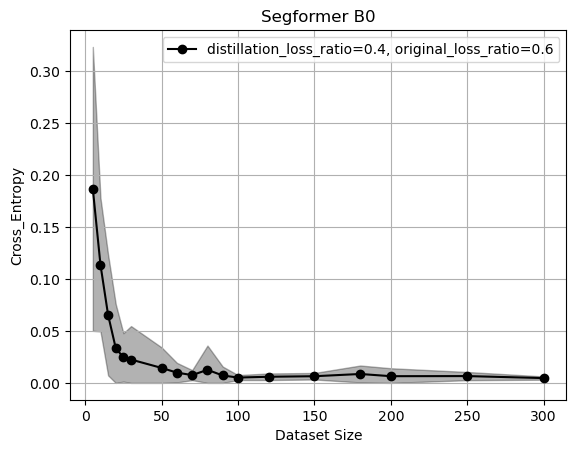

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0616')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.png"))

plt.show()